# (1) Athlete notebook

This notebook is supposed to visualise my implementation of a simulated athlete that will later be tracked with a sensor. My athlete implementation has a football player in mind.

The implementation is based on the following idea:
* As main arguments, the athlete takes the limits of the movement (`limits`), its initial position (`pos0`) and velocity (`vel0`), its maximum acceleration (`amax`) and velocity (`vmax`).
* The athlete starts from an initial position (by default the center of the field and zero  velocity).
* Once instantiated, it can be called with a time and returns an `AthleteSpec` object containing its position and velocity at that time; if the flag `keepdata` is `True`, it furthermore adds the result to its own `data` list.
* At each evaluation, the athlete randomly decides if it wants to accelerate or decelerate. The `acc_freq` parameter specifies how often it accelerates (every 5 seconds by default).
* If it decelerates, it does so by a constant amount given by parameter `dec_a`.
* If it accelerates, it draws a random acceleration magnitude between zero and `amax` and a random direction.
* It updates position and velocity according to the acceleration and deceleration and is reflected at the boundaries.

The implementation ensures that the athlete is moving randomly, but smoothly. This means that the athlete is not abruptly changing direction or velocity. While the `amax` and `vmax` parameters are chosen to approximately match the maximum velocity and acceleration of a real athlete, the `dec_a` and `acc_freq` parameters are chosen such that the overall distance of the athlete is close to 10 km after 90 minutes, i.e. similar to the distance of an actual pro-football player. Increasing the `dec_a` parameter results in a stronger deceleration, hence decreases the reach of the athlete. Increasing the `acc_freq` parameter results in a more frequent acceleration of the athlete, hence increases the reach of the athlete.

## Imports

In [37]:
%matplotlib inline

In [38]:
import numpy as np

In [39]:
import matplotlib.pyplot as plt

In [40]:
import seaborn as sns

In [41]:
sns.set_context('notebook')

In [42]:
from datetime import datetime, timedelta

In [43]:
from streamanalysis import Athlete

## Data generation

I create an athlete that moves between 0 and 100 in both x and y direction. Its highest acceleration is $4\,{\rm m}/{\rm s^2}$ and the highest velocity $9\,{\rm m}/{\rm s}$ (approximately $30\,{\rm km}/{\rm h}$). I choose to set the `keepdata` flag to `True` in order to keep the created data in a list at `athlete.data`. Each data point is an `AthleteSpec` instance, i.e. a named tuple containing speed and velocity of the athlete.

In [44]:
limits = np.array([100., 100.])
amax = 4.0 # meter / second^2
vmax = 9.0 # meter / second
athlete = Athlete(limits = limits, amax = amax, vmax = vmax, keepdata = True, seed = 1)

I evaluate the player over 90 minutes, i.e. one football match, at a frequency of 20 Hz that I will later use for the sensor.

In [45]:
# Current time used for initialization of the athlete
time = datetime.now()
# Time interval in seconds during which I evaluate the athlete (corresponds to 20 Hz)
dt = 1./20.
# Number of evaluations (corresponds to 90 minutes)
N = 20 * 60 * 90 + 1
# Reset player (set it back to initial conditions in case it was already activated before)
athlete.reset()
for i in range(N):
    _=athlete(time + timedelta(seconds = i*dt))

## Analysis of generated data

I can now look at the positions and velocities of the athlete as stored in `athlete.data`.

In [46]:
# Get data from player
data = athlete.data

Each element of the data list is a `AthleteSpec` instance. `AthleteSpec` is a `namedtuple` containing the velocity (`vel`) and position (`pos`) of the athlete.

In [54]:
print 'Initial data of athlete:'
print 'Position', data[0].pos
print 'Velocity', data[0].vel
print 'Final data of athlete:'
print 'Position', data[-1].pos
print 'Velocity', data[-1].vel

Initial data of athlete:
Position [ 50.  50.]
Velocity [ 0.  0.]
Final data of athlete:
Position [ 97.81555091  48.63679544]
Velocity [ 0.12691464  0.30317244]


In [55]:
# Get positions and velocities from data as a numpy array (more convenient for plotting)
d = np.asarray(data)
positions = d[:,0]
velocities = d[:,1]

In [57]:
print 'I expect %i data points and the positions have shape'%N, positions.shape

I expect 108001 data points and the positions have shape (108001, 2)


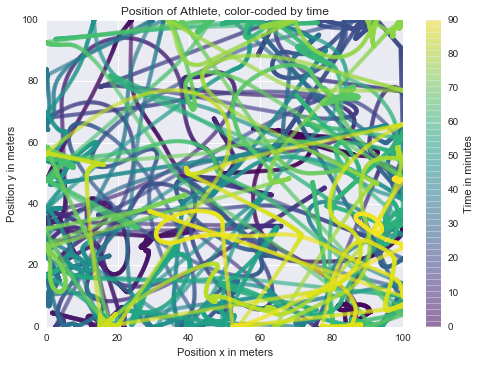

In [49]:
time = np.arange(positions.shape[0]) * (dt/60.)
plt.scatter(positions[:,0], positions[:,1], c = time, alpha = .3, cmap = 'viridis',edgecolors='none')
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
plt.title('Position of Athlete, color-coded by time')
_=plt.colorbar(label = 'Time in minutes')

This plot shows the positions of the athlete over the full 90 minutes color coded by the ellapsed time (see colorbar). The athlete nicely covers most of the field and the trajectory appears smooth.

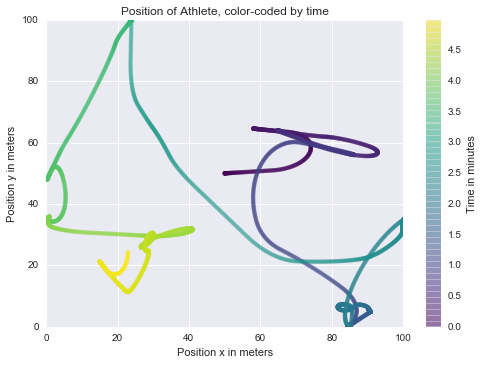

In [50]:
start = 60*20*5
plt.scatter(positions[:start,0], positions[:start,1], c = time[:start], alpha = .3, cmap = 'viridis',edgecolors='none')
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
plt.title('Position of Athlete, color-coded by time')
_=plt.colorbar(label = 'Time in minutes')

This plot is a closer look at the first 5 minutes only. I will later use the first five minutes for analysing the performance of the `Sensor` and `Analysis` implementations.

In [23]:
# Calculate absolute velocities
vs = np.sqrt((velocities**2).sum(axis = 1))

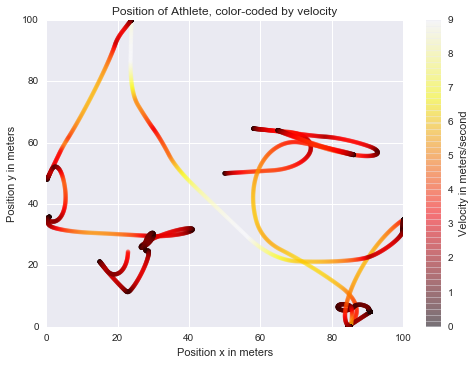

In [25]:
plt.scatter(positions[:start,0], positions[:start,1], c = vs[:start], alpha = .3, cmap = 'hot',edgecolors='none')
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
plt.colorbar(label = 'Velocity in meters/second')
_=plt.title('Position of Athlete, color-coded by velocity')

This plot again shows the positions of the athlete over the first 5 minutes, this time color coded by the velocity of the athlete. The athlete achieves the highest speeds on long, straight trajectories and is slow when it turns around.

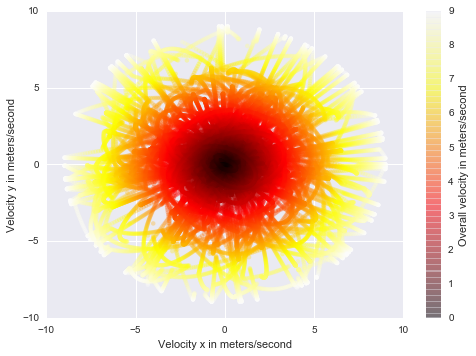

In [36]:
plt.scatter(velocities[:,0], velocities[:,1], c = vs, alpha = .3, cmap = 'hot',edgecolors='none')
plt.xlim(-10,10)
plt.xlabel('Velocity x in meters/second')
plt.ylim(-10,10)
plt.ylabel('Velocity y in meters/second')
_=plt.colorbar(label = 'Overall velocity in meters/second')

Velocities of athlete in x and y direction, color coded by the overall velocity. The athlete does not prefer a particular direction. The nice circular structure of the trace in velocity-space also shows that the maximum speed of the athlete is indeed limited by 9 m/s.

In [51]:
# Calculate the covered distance in kilometers as a function of time
delta_pos = np.sqrt(((positions[1:] - positions[:-1])**2).sum(axis = 1))
distance_covered = np.cumsum(delta_pos)/1000.0

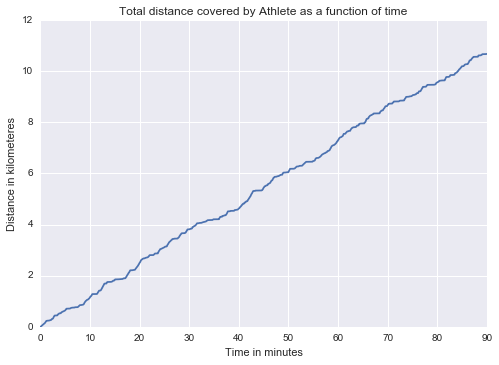

In [52]:
plt.plot(time[1:], distance_covered)
plt.xlabel('Time in minutes')
plt.ylabel('Distance in kilometeres')
_=plt.title('Total distance covered by Athlete as a function of time')

Total distance covered by the athlete as a function of time. At the end of the game, the athlete travelled almost 11 km. The reach could be modified by modifying the `dec_a` and `acc_freq` parameters, but 11 km is a reasonable distance for a professional football player.